In [ ]:
import pandas as pd
import numpy
import matplotlib.pyplot  as plt
import missingno as msno
import plotly.express as px
import random as rd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from utils.plot_stromerzeugung import (plot_solar_generation_seasonal_heatmap)
from utils.finde_zusammenhang import(plot_attribute_vs_label_filtered)

In [2]:
df_forecast = pd.read_parquet('../Daten/forecasts.parquet')

df_test1 = pd.read_parquet('../Daten/energy_test1.parquet')

df_test2 = pd.read_parquet('../Daten/energy_test2.parquet')

df_train = pd.read_parquet('../Daten/energy_train.parquet')

# Soloar Porwer Datensatz Analyse
---

### Augabe 1

---

### Aufgabe 1.1:

Wie viele Datenpunkte, die vorhergesagt werden sollen, gibt es in den Trainings- bzw. Testdaten?

In [3]:
total_data_points_energy_train = len(df_train)
total_data_points_energy_test1 = len(df_test1)
total_data_points_energy_test2 = len (df_test2)

# Anzahl der fehlenden Zielwerte (falls NaN verwendet wird)
missing_values = df_train['Solar_MWh'].isna().sum()

# Falls '0.0' Zielwerte bedeutet, zählen Sie diese
zero_values = (df_train['Solar_MWh'] == 0.0).sum()

print("="*40)
print(f"🔹 Gesamte Datenpunkte im Trainingsdatensatz: {total_data_points_energy_train}")
print(f"🔹 Gesamte Datenpunkte im Testdatensatz 1:   {total_data_points_energy_test1}")
print(f"🔹 Gesamte Datenpunkte im Testdatensatz 2:   {total_data_points_energy_test2}")
print("="*40)

🔹 Gesamte Datenpunkte im Trainingsdatensatz: 19968
🔹 Gesamte Datenpunkte im Testdatensatz 1:   7245
🔹 Gesamte Datenpunkte im Testdatensatz 2:   7465


---
### Aufgabe 1.2:

Visualisieren Sie den Tagesverlauf der Stromerzeugung für zufällig ausgewählte Tage, z.B. die Ge-
burtstage der Teammitglieder. Beschreiben Sie die Kurven.

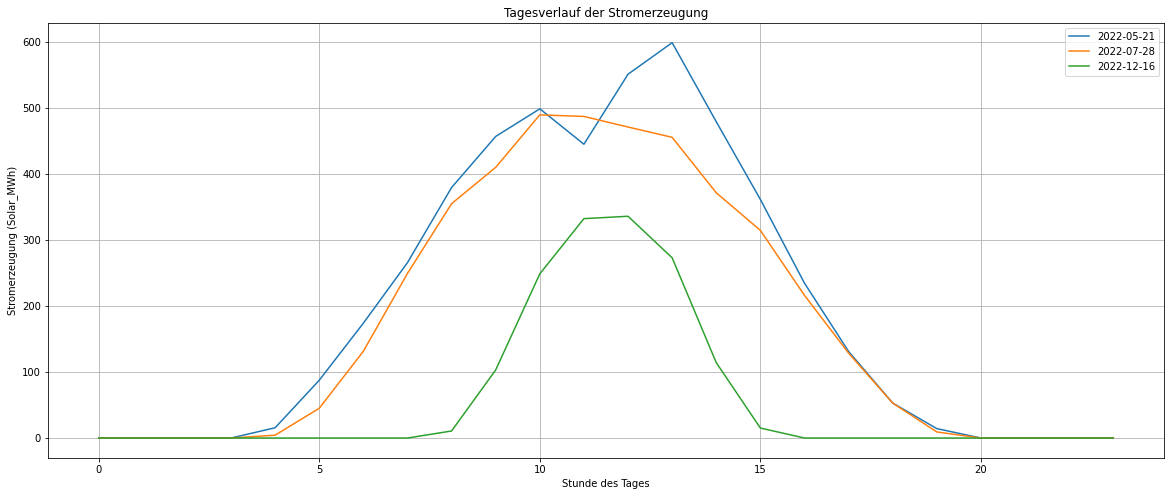

In [4]:
birthdates = ["2022-05-21", "2022-07-28", "2022-12-16"]
birthdates = pd.to_datetime(birthdates) # Strings in datetime umwandeln

df_train["date"] = pd.to_datetime(df_train["dtm"]).dt.date  # Extrahiere das Datum

# Filter für die ausgewählten Tage
filtered_data = df_train[df_train["date"].isin(birthdates.date)]

# Plot
plt.figure(figsize=(20, 8))
for date in birthdates:
    daily_data = filtered_data[filtered_data["date"] == date.date()]
    plt.plot(
        pd.to_datetime(daily_data["dtm"]).dt.hour,
        daily_data["Solar_MWh"],
        label=str(date.date())
    )
plt.xlabel("Stunde des Tages")
plt.ylabel("Stromerzeugung (Solar_MWh)")
plt.title("Tagesverlauf der Stromerzeugung")
plt.legend()
plt.grid()
plt.show()


df_train = df_train.drop(columns=["date"])

#### Beschreibung der Kurven:
- Jahreszeit scheint eine Rolle zu spielen:
  - Tendenziell höhere Energieproduktion im Sommer
  - Anderer Kurvenverlauf: Größerer Tageszeitraum
- Tageszeitraum entscheidend:
  - Keine Produktion nachts
  - Mitte des Tages mehr

---
### Aufgabe 1.3:

Visualisieren Sie den Gesamtverlauf der Stromerzeugung für den Zeitraum der Trainingsdaten.
Beschreiben Sie die Kurve.

In [5]:
px.line(df_train, x='dtm', y='Solar_MWh', title='Gesamtverlauf der Energieproduktion')

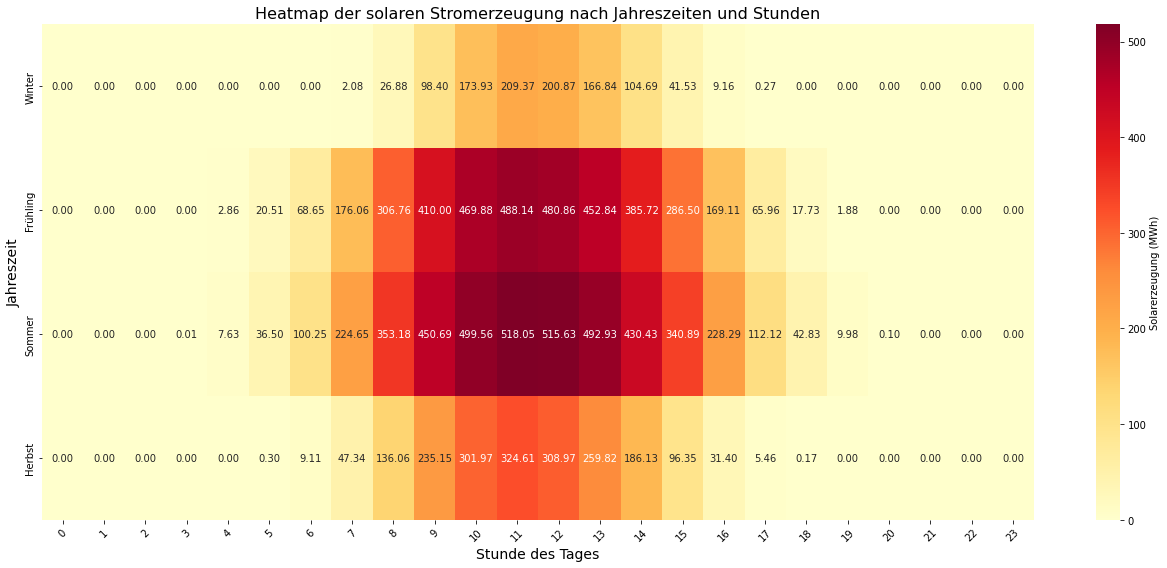

In [6]:
plot_solar_generation_seasonal_heatmap(df_train)

#### Beschreibung der Kurve:
- Sehr schwankend => starkes Rauschen
- Saisonalität erkennbar => Jahreszeitenabhängig
- Im Sommer steigt die Stromerzeugung, da es länger hell bleibt und wenig Wolkenbedeckung hat.
- Im Winter sinkt die Stromerzeugung, da es schneller dunkel wird und weniger Sonnenschein tagsüber hat.

---


### Aufgabe 2

---

### Aufgabe 2.1
Erzeugen Sie Plots, aus denen man einen möglichen Zusammenhang zwischen Label und Attri-
buten erkennen kann

In [26]:
# Transformiere "ref_datetime" und "dtm" zu datetime
df_train["ref_datetime"] = pd.to_datetime(df_train["ref_datetime"])
df_train["dtm"] = pd.to_datetime(df_train["dtm"])
df_forecast["ref_datetime"] = pd.to_datetime(df_forecast["ref_datetime"])

# Gültigen Zeitpunkt für Wettervorhersagen berechnen
df_forecast["valid_datetime"] = df_forecast["ref_datetime"] + pd.to_timedelta(df_forecast["valid_time"], unit="h")

df_merged = pd.merge(
    df_train,
    df_forecast,
    left_on=["dtm", "ref_datetime"],
    right_on=["valid_datetime", "ref_datetime"],
    how="inner"
)

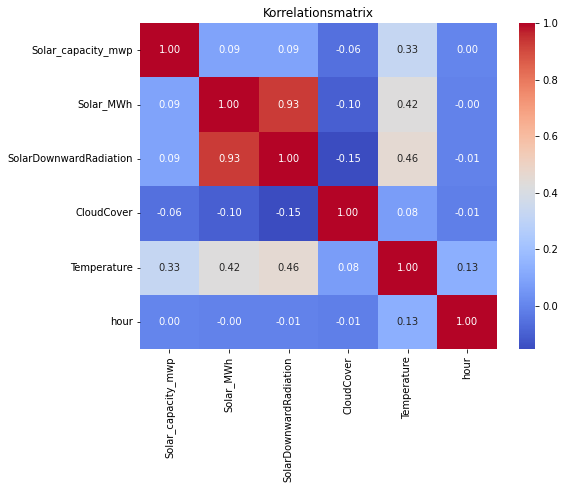

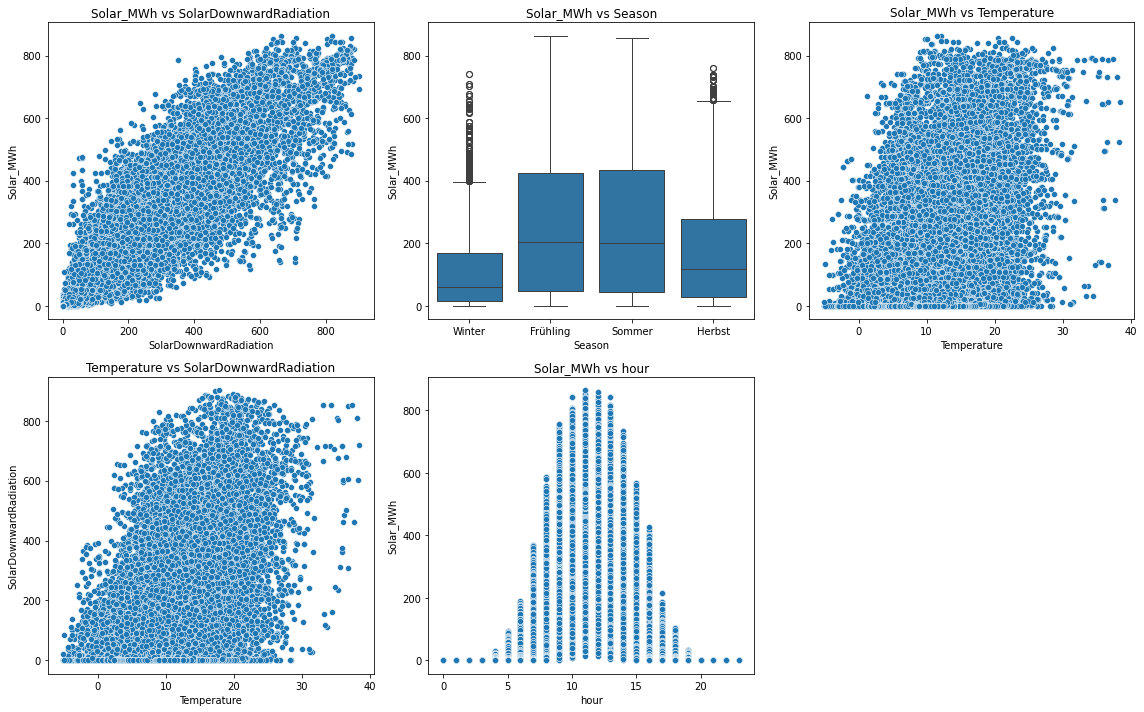

In [8]:
plot_attribute_vs_label_filtered(df_merged)


---
### Augabe 3
---

Führen Sie basierend aus den Analysen der vorherigen Aufgaben geeignete Vorverarbeitungsschritte
durch, z.B. Behandlung von Ausreißern und fehlenden Werten, Skalierung der Daten.

In [21]:
anzahl_zeilen_mit_na = df_forecast[df_forecast.SolarDownwardRadiation.isna()]
print(f'Anzahl der Zeilen mit fehlenden Wert bei SolarDownwardRadiation: {len(anzahl_zeilen_mit_na)}')

anzahl_zeilen_mit_na = df_forecast[df_forecast.Temperature.isna()]
print(f'Anzahl der Zeilen mit fehlenden Wert bei Temperature: {len(anzahl_zeilen_mit_na)}')

anzahl_zeilen_mit_na = df_forecast[df_forecast.CloudCover.isna()]
print(f'Anzahl der Zeilen mit fehlenden Wert bei CloudCover: {len(anzahl_zeilen_mit_na)}')

anzahl_zeilen_mit_na = df_train[df_train.Solar_MWh.isna()]
print(f'Anzahl der Zeilen mit fehlenden Wert bei Solar_MWh: {len(anzahl_zeilen_mit_na)}')


Anzahl der Zeilen mit fehlenden Wert bei SolarDownwardRadiation: 1226
Anzahl der Zeilen mit fehlenden Wert bei Temperature: 303
Anzahl der Zeilen mit fehlenden Wert bei CloudCover: 375
Anzahl der Zeilen mit fehlenden Wert bei Solar_MWh: 4


## Umgang mit NaN-Werten

__Umgang mit NaN-Werten in df_train__
- Betroffene Zeilen 4 von 19968 (ca.0,02%)
- Mein Ansatz: Zeilen, wo bei `Solar_MWh` NaN auftaucht, löschen

In [22]:
df_train = df_train.dropna(subset=["Solar_MWh"])

**Umgang mit NaN-Werten in df_forecasts**
- Betroffene Zeilen: max. 1226 von 606797 (ca. 0,2%)
- Mein Ansatz: Daten behalten und Auffüllen

In [24]:
# Spalte SolarDownwardRadiation
df_forecast = df_forecast.dropna(subset=["SolarDownwardRadiation"])

# Spalte CloudCover
df_forecast = df_forecast.dropna(subset=["CloudCover"])

# Spalte Temperature
df_forecast = df_forecast.dropna(subset=["Temperature"])

In [25]:
df_forecast["SolarDownwardRadiation"] = df_forecast["SolarDownwardRadiation"].clip(lower=0)

In [ ]:
# Transformiere "ref_datetime" und "dtm" zu datetime
df_train["ref_datetime"] = pd.to_datetime(df_train["ref_datetime"])
df_train["dtm"] = pd.to_datetime(df_train["dtm"])
df_forecast["ref_datetime"] = pd.to_datetime(df_forecast["ref_datetime"])

# Gültigen Zeitpunkt für Wettervorhersagen berechnen
df_forecast["valid_datetime"] = df_forecast["ref_datetime"] + pd.to_timedelta(df_forecast["valid_time"], unit="h")

df_merged = pd.merge(
    df_train,
    df_forecast,
    left_on=["dtm", "ref_datetime"],
    right_on=["valid_datetime", "ref_datetime"],
    how="inner"
)

In [171]:
# scalieren und onehotencoding
# Auswahl der zu skalierenden Spalten
scaling_columns = ["SolarDownwardRadiation", "CloudCover", "Temperature", "Solar_capacity_mwp"]
scaler = StandardScaler()

# Skalierung anwenden
df_merged[scaling_columns] = scaler.fit_transform(df_merged[scaling_columns])

In [ ]:
# # train model
# X = df_merged[["SolarDownwardRadiation", "Temperature", "Season_Winter", "Season_Spring", "Season_Summer", "Season_Autumn", "CloudCover", "Solar_capacity_mwp"]]
# y = df_merged["Solar_MWh"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# model = Ridge(alpha=0.1)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)

# print(f"Mean Squared Error: {mse}")
# rmse = numpy.sqrt(mse)
# print(f"Root Mean Squared Error: {rmse}")

KeyError: "['Season_Spring', 'Season_Summer', 'Season_Autumn'] not in index"

In [197]:
# StandardScaler + Onehotencoding
scaling_columns = ["SolarDownwardRadiation", "CloudCover", "Temperature", "Solar_capacity_mwp"]
scaler = StandardScaler()

df_merged[scaling_columns] = scaler.fit_transform(df_merged[scaling_columns])

categorical_columns = ['Season', 'hour', "Weather Model"]
df_merged = pd.get_dummies(df_merged, columns=categorical_columns)

print(df_merged.head())


                        dtm              ref_datetime  Solar_capacity_mwp  \
0 2020-09-21 00:00:00+00:00 2020-09-20 00:00:00+00:00           -0.135082   
1 2020-09-21 00:00:00+00:00 2020-09-20 00:00:00+00:00           -0.135082   
2 2020-09-21 01:00:00+00:00 2020-09-20 00:00:00+00:00           -0.135082   
3 2020-09-21 01:00:00+00:00 2020-09-20 00:00:00+00:00           -0.135082   
4 2020-09-21 02:00:00+00:00 2020-09-20 00:00:00+00:00           -0.135082   

   Solar_MWh  valid_time  SolarDownwardRadiation  CloudCover  Temperature  \
0        0.0          24               -0.624860   -0.912255     0.289505   
1        0.0          24               -0.624860   -1.872801     0.293458   
2        0.0          25               -0.624810   -0.592892     0.255763   
3        0.0          25               -0.624860   -1.869853     0.258539   
4        0.0          26               -0.624774   -0.496516     0.221716   

             valid_datetime  Season_Winter  ...  hour_16  hour_17  hour_18

In [47]:
df_cleaned

,Solar_capacity_mwp,Solar_MWh,valid_time,SolarDownwardRadiation,CloudCover,Temperature,Season_Winter,Season_Frühling,Season_Sommer,Season_Herbst,...,ref_datetime_weekday_1,ref_datetime_weekday_2,ref_datetime_weekday_3,ref_datetime_weekday_4,ref_datetime_weekday_5,ref_datetime_weekday_6,ref_datetime_quarter_1,ref_datetime_quarter_2,ref_datetime_quarter_3,ref_datetime_quarter_4
0,-0.135082,0.0,24,-0.624860,-0.912255,0.289505,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
1,-0.135082,0.0,24,-0.624860,-1.872801,0.293458,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
2,-0.135082,0.0,25,-0.624810,-0.592892,0.255763,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
3,-0.135082,0.0,25,-0.624860,-1.869853,0.258539,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
4,-0.135082,0.0,26,-0.624774,-0.496516,0.221716,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39555,1.062759,0.0,27,-0.624860,1.069944,0.318090,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True
39556,1.062759,0.0,28,-0.624860,1.069103,0.187818,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True
39557,1.062759,0.0,28,-0.624860,1.069944,0.342720,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True
39558,1.424270,0.0,29,-0.624848,1.069944,0.108587,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True
